##ANN_model_sub classing

used data : MNIST(28*28 Matrix = 784 pixel)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy

In [2]:
def load_mnist_dataset(TRAIN_BATCH_SIZE, TEST_BATCH_SIZE):
    (train_validation_images,train_validation_labels),(test_images,test_labels)\
    = mnist.load_data()#load data&define data

    train_validation_ds = tf.data.Dataset.from_tensor_slices\
    ((train_validation_images, train_validation_labels))
    test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

    n_train_validation =train_validation_images.shape[0]
    train_ratio = 0.8
    n_train = int(n_train_validation * train_ratio)
    n_validation = n_train_validation - n_train
    train_ds = train_validation_ds.take(n_train)
    remaining_ds = train_validation_ds.skip(n_train)
    validation_ds = remaining_ds.take(n_validation)
    n_test = test_images.shape[0]

    def normalize(images, labels):
        images = tf.cast(images, tf.float32) / 255. #resize data
        return (images, labels)

    train_ds = train_ds.map(normalize).\
    shuffle(1000).batch(TRAIN_BATCH_SIZE)
    validation_ds = validation_ds.map(normalize).\
    shuffle(1000).batch(TEST_BATCH_SIZE)
    test_ds = test_ds.map(normalize).\
    shuffle(1000).batch(TEST_BATCH_SIZE)

    print('Train set', n_train)
    print(train_ds)
    print('Validation set', n_validation)
    print(validation_ds)
    print('Test set', n_test)
    print(test_ds)

    return train_ds, validation_ds, test_ds

In [3]:
#build ANN model

class MNIST_ANN_Classfier(Model):
  def __init__(self):
    super(MNIST_ANN_Classfier, self).__init__()

    self.flatten=Flatten()
    self.d1=Dense(128, activation='relu')
    self.d2=Dense(64, activation='relu')
    self.d3=Dense(10, activation='softmax')

  def call(self, x):
    x=self.flatten(x)
    x=self.d1(x)
    x=self.d2(x)
    x=self.d3(x)
    return x

In [4]:
#define loss and accuracy metrics
def load_metrics():
  global train_loss, train_acc
  global validation_loss, validation_acc
  global test_loss, test_acc

  train_loss = Mean()
  validation_loss = Mean()
  test_loss = Mean()
  train_acc = SparseCategoricalAccuracy()
  validation_acc = SparseCategoricalAccuracy()
  test_acc = SparseCategoricalAccuracy()

In [5]:
#define trainer
def trainer():
  global train_ds, model, loss_object, optimizer
  global train_loss, train_acc
  for x, y in train_ds:
    with tf.GradientTape() as tape:
      predictions = model(x)
      loss = loss_object(y, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_acc(y, predictions)

In [6]:
#define validation
def validation():
  global validation_ds, model, loss_object
  global validation_loss, validation_acc

  for x, y in validation_ds:
    predictions = model(x)
    loss = loss_object(y, predictions)

    validation_loss(loss)
    validation_acc(y, predictions)

In [7]:
#define train_reporter
def train_reporter():
  global epoch
  global train_loss, train_acc
  global validation_loss, validation_acc
  global train_losses, train_accs
  global validation_losses, validation_accs

  train_losses.append(train_loss.result())
  train_accs.append(train_acc.result()*100)
  validation_losses.append(validation_loss.result())
  validation_accs.append(validation_acc.result()*100)

  template = 'Train Loss: {:.4f}\t Train Accuracy : {:.2f}%\n' +\
            'Validation Loss: {:.4f}\t Validation Accuracy : {:.2f}%\n'

  print(template.format(train_loss.result(),
                        train_acc.result()*100,
                        validation_loss.result(),
                        validation_acc.result()*100))

  train_loss.reset_states()
  train_acc.reset_states()
  validation_loss.reset_states()
  validation_acc.reset_states()

In [8]:
#define plot_loss
def plot_loss():
  global train_losses, train_accs
  global validation_losses, validation_accs

  fig, axes = plt.subplots(2,1)

  axes[0].plot(train_losses, label='Train loss')
  axes[0].plot(validation_losses, label='Validation loss')
  axes[0].set_ylabel('Crossentropy')
  axes[0].legend()

  axes[1].plot(train_accs, label='Train accuracy')
  axes[1].plot(validation_accs, label='Validation accuracy')
  axes[1].set_ylabel('Accuarcy')
  axes[1].legend()
  axes[1].set_xlabel('Epochs')


In [9]:
#define tester
def tester():
  global test_ds, model, loss_object
  global test_loss, test_acc

  for x, y in test_ds:
    predictions = model(x)
    loss = loss_object(y, predictions)

    test_loss(loss)
    test_acc(y, predictions)

    template = 'Test Loss: {:.4f}\t Test Accuracy : {:.2f}%\n'

  print(template.format(test_loss.result(),
                        test_acc.result()*100))

In [10]:
#define pot_result_sample
def plot_result_sample():
  global test_ds, model, loss_object
  global test_loss, test_acc

  test_ds_iter = iter(test_ds)
  images, labels = next(test_ds_iter)
  predictions = model(images)

  fig, axes = plt.subplots(4, 4, figsize=(10,10))

  for ax_idx, ax in enumerate(axes.flat):
    ax.imshow(images[ax_idx,...].numpy(), 'gray')
    ax.set_title('Prediction : {}'\
                 .format(np.argmax(predictions[ax_idx].numpy())))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [11]:
TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

train_ds, validation_ds, test_ds = load_mnist_dataset(TRAIN_BATCH_SIZE,\
                                                      TEST_BATCH_SIZE)

11490434/11490434 [==============================] - 0s 0us/step
Train set 48000
<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>
Validation set 12000
<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>
Test set 10000
<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>


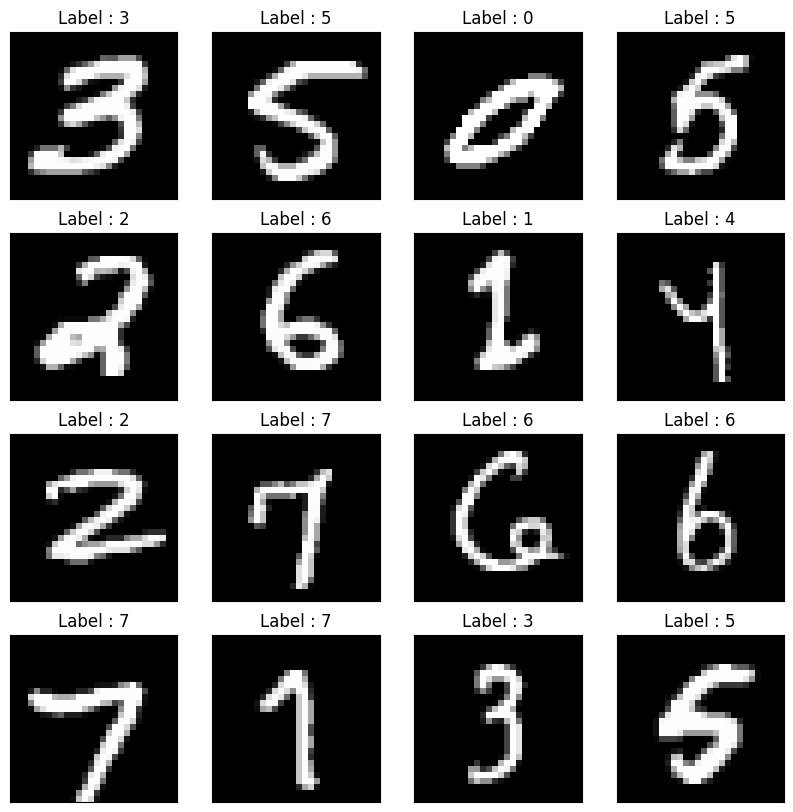

In [12]:
train_ds_iter = iter(train_ds)
images, labels = next(train_ds_iter)

fig, axes = plt.subplots(4, 4, figsize=(10,10))

for ax_idx, ax in enumerate(axes.flat):
  ax.imshow(images[ax_idx,...].numpy(), 'gray')
  ax.set_title('Label : {}'.format(labels[ax_idx].numpy()))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

In [13]:
#run function
model = MNIST_ANN_Classfier()

EPOCHS = 10
LR = 0.001

loss_object = SparseCategoricalCrossentropy()
optimizer = Adam(learning_rate=LR)

load_metrics()

train_losses, train_accs = [], []
validation_losses, validation_accs = [], []

for epoch in range(EPOCHS):
  print('Epoch : {}'.format(epoch+1))
  trainer()
  validation()
  train_reporter()

Epoch : 1
Train Loss: 0.2305	 Train Accuracy : 93.31%
Validation Loss: 0.1385	 Validation Accuracy : 95.82%

Epoch : 2
Train Loss: 0.1030	 Train Accuracy : 96.85%
Validation Loss: 0.1313	 Validation Accuracy : 96.19%

Epoch : 3
Train Loss: 0.0717	 Train Accuracy : 97.85%
Validation Loss: 0.1043	 Validation Accuracy : 96.96%

Epoch : 4
Train Loss: 0.0542	 Train Accuracy : 98.28%
Validation Loss: 0.1032	 Validation Accuracy : 97.09%

Epoch : 5
Train Loss: 0.0421	 Train Accuracy : 98.63%
Validation Loss: 0.1124	 Validation Accuracy : 97.03%

Epoch : 6
Train Loss: 0.0347	 Train Accuracy : 98.86%
Validation Loss: 0.1125	 Validation Accuracy : 97.28%

Epoch : 7
Train Loss: 0.0303	 Train Accuracy : 98.98%
Validation Loss: 0.1253	 Validation Accuracy : 96.99%

Epoch : 8
Train Loss: 0.0239	 Train Accuracy : 99.21%
Validation Loss: 0.1459	 Validation Accuracy : 96.72%

Epoch : 9
Train Loss: 0.0230	 Train Accuracy : 99.21%
Validation Loss: 0.1303	 Validation Accuracy : 97.14%

Epoch : 10
Train Lo

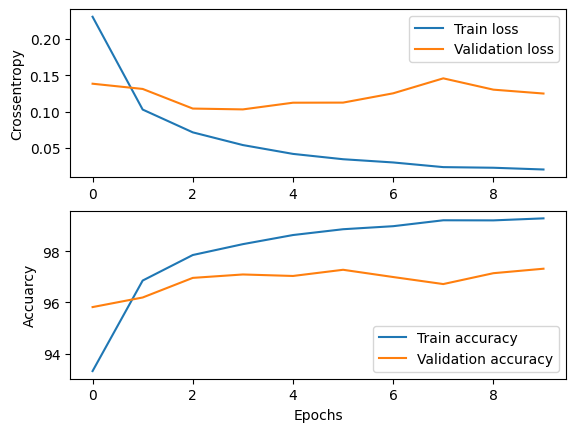

In [14]:
plot_loss()

In [15]:
tester()

Test Loss: 0.1063	 Test Accuracy : 97.62%



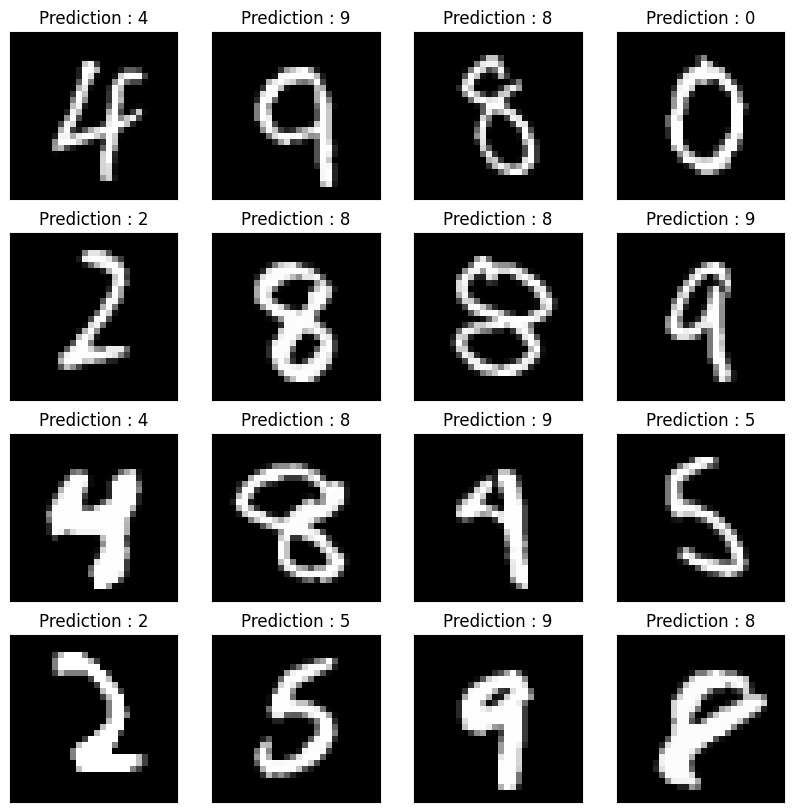

In [16]:
plot_result_sample()

In [17]:
#Feature dimension
X = tf.random.uniform(shape=(1, 28, 28, 1))
for layer in MNIST_ANN_Classfier().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Flatten output shape:	 (1, 784)
Dense output shape:	 (1, 128)
Dense output shape:	 (1, 64)
Dense output shape:	 (1, 10)
